<a href="https://colab.research.google.com/github/trefftzc/cis677/blob/main/Numba_cuda_tutorial_by_Carlos_Costa_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on the numba/cuda tutorial by Carlos Costa Ph.D.

This is the web page of his tutorial (part 1)

https://medium.com/data-science/cuda-by-numba-examples-1-4-e0d06651612f

A very minor change was made to the source code
in one of the cells to make sure that it works with the current version of numba/cuda (2025).

# Introduction

GPUs (graphics processing units), as the name implies, were originally developed for computer graphics. Since then, they have become ubiquitous in almost every area that requires high computational throughput. This progress has been enabled by the development of GPGPU (general purpose GPU) interfaces, which allow us to program GPUs for general-purpose computing. The most common of these interfaces is CUDA, followed by OpenCL and most recently, HIP.

# CUDA in Python

CUDA was originally designed to be compatible with C. Later versions extended it to C++ and Fortran. In the Python ecosystem, one of the ways of using CUDA is through Numba, a Just-In-Time (JIT) compiler for Python that can target GPUs (it also targets CPUs, but that’s outside of our scope). With Numba, one can write kernels directly with (a subset of) Python, and Numba will compile the code on-the-fly and run it. While it does not implement the complete CUDA API, its supported features are often enough to obtain impressive speedups compared to CPUs (for all missing features, see the Numba documentation).

Numba is not the only option, however. CuPy offers both high level functions which rely on CUDA under the hood, low-level CUDA support for integrating kernels written in C, and JIT-able Python functions (similar to Numba). PyCUDA provides even more fine-grained control of the CUDA API. More recently, Nvidia released the official CUDA Python, which will surely enrich the ecosystem. All of these projects can pass device arrays to each other, you are not locked into using only one.


#In This Tutorial

We will learn how to run our first Numba CUDA kernel. We will also learn how to use CUDA efficiently for embarrassingly parallel tasks, that is, tasks which are completely independent from each other. Finally, we will learn how to time our kernel runtimes from the CPU.


In [3]:

!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

find: ‘/proc/61/task/61/net’: Invalid argument
find: ‘/proc/61/net’: Invalid argument
/root/.julia/artifacts/6283886c5dd600750885a23bff8d37f687172633/share/libdevice
/usr/local/lib/python3.12/dist-packages/nvidia/cuda_nvcc/nvvm/libdevice
/usr/local/cuda-12.5/nvvm/libdevice
find: ‘/proc/61/task/61/net’: Invalid argument
find: ‘/proc/61/net’: Invalid argument
/usr/local/lib/python3.12/dist-packages/nvidia/cuda_nvcc/nvvm/lib64/libnvvm.so
/usr/local/cuda-12.5/nvvm/lib64/libnvvm.so


In [4]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-12.5/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-12.5/nvvm/lib64/libnvvm.so"

In [5]:

!uv pip install -q --system numba-cuda==0.15

In [6]:
import numpy as np

import numba
from numba import cuda

print(np.__version__)
print(numba.__version__)

2.0.2
0.60.0


In [7]:
cuda.detect()

Found 1 CUDA devices
id 0    Tesla T4                                                                                                                                                      [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-152664a4-6059-9db1-fda6-24987ea0d514
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

The main workhorse of Numba CUDA is the cuda.jit decorator. It is used to define functions which will run in the GPU.

We'll start by defining a simple function, which takes two numbers and stores them on the first element of the third argument. Our first lesson is that kernels (GPU functions that launch threads) cannot return values. We get around that by passing inputs and outputs. This is a common pattern in C, but not very common in Python.

In [10]:
#Example 1.1: Add scalars
@cuda.jit
def add_scalars(a, b, c):
    c[0] = a[0] + b[0]

In [12]:
import cupy as cp
import numpy as np
a = np.array([2.0])
b = np.array([7.0])
c = np.array([0.0])

a_gpu= cp.asarray(a)
b_gpu= cp.asarray(b)
c_gpu= cp.asarray(c)
add_scalars[1, 1](a_gpu,b_gpu, c_gpu)

# Copy the data from the gpu to the cpu
c = c_gpu.get()
print(f"2.0 + 7.0 = {c[0]}")

2.0 + 7.0 = 9.0


As you may have noticed, before we call the kernel, we need to allocate an array on the device. In addition, if we want to display the returned value, we need to copy it back to the CPU. You might be asking yourself why we chose to allocate a float32 (single-precision float). This is because, while supported in most modern GPUs, double precision arithmetic can take 4x or longer than single precision arithmetic. So it's better to get used to using np.float32 and np.complex64 instead of float/np.float64 and complex/np.complex128.

Whereas the kernel definition looks similar to a CPU function, the kernel call is a little different. In particular, it has square brackets before the arguments:

add_scalars[1, 1](a_gpu,b_gpu, c_gpu)

These square brackets refer to the number of blocks in a grid, and the number of threads in a block, respectively. Let’s talk a little bit more about what these mean as we learn to parallelize with CUDA.

# Parallelization with CUDA

The anatomy of a CUDA grid
When a kernel is launched it has a grid associated with it. A grid is composed of blocks; a block is composed of threads. Figure 2 shows a one dimensional CUDA grid. The grid in the figure has 4 blocks. The number of blocks in a grid is held in a special variable which can be accessed inside the kernel called gridDim.x. The .x is refers to the first dimensional of the grid (the only one in this case). Two dimensional grids also have .y and three dimensional grids, .z variables. As of 2022, there are no 4-dimensional grids or higher. Also inside the kernel, you can find out which block is being executed through the use of blockIdx.x, which in this case will run from 0 to 3.

Each block has a certain number of threads, held in the variable blockDim.x. Thread indices are held in the variable threadIdx.x, which in this example will run from 0 to 7.

Importantly, threads in different blocks are scheduled to run differently, have access to different memory regions, and differ in some other ways (see CUDA Refresher: The CUDA Programming Model for a brief discussion
https://developer.nvidia.com/blog/cuda-refresher-cuda-programming-model/). For now, we will skip these details.

When we launched the kernel in our first example with parameters [1, 1], we told CUDA to run one block with one thread. Passing several blocks with several threads, will run the kernel many times. Manipulating threadIdx.x and blockIdx.x will allow us to uniquely identify each thread.

Instead of summing two numbers, let’s try to sum two arrays. Suppose the arrays each have 20 elements. Like in the figure above, we can launch a kernel with 8 threads per block. If we want each thread to handle only one array element, we will then need at least 4 blocks. Launching 4 blocks, 8 threads each, our grid will then launch 32 threads.
Now we need to figure out how to map the thread indices to the array indices. threadIdx.x runs from 0 to 7, so on their own they are not able to index our array. In addition, different blocks have the same threadIdx.x. On the other hand, they have different blockIdx.x. To obtain a unique index for each thread, we can combine these variables:

i = threadIdx.x + blockDim.x * blockIdx.x

For the first block, blockIdx.x = 0 and i will run from 0 to 7. For the second block, blockIdx.x = 1. Since blockDim.x = 8, i will run from 8 to 15. Similarly, for blockIdx.x = 2, i will run from 16 to 23. In the fourth and final block, i will run from 24 to 31.

| `i`           | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    | 10   | 11   | 12   | 13   | 14   | 15   | 16   | ...   | 31   |
| ----------- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| `threadIdx.x` | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 0    | ...    | 7    |
| `blockIdx.x`  | 0    | 0    | 0    | 0    | 0    | 0    | 0    | 0    | 1    | 1    | 1    | 1    | 1    | 1    | 1    | 1    | 2    | ...    | 3    |

We solved one problem: how to map each thread to each element in the array… but now we have an issue where some threads would overflow the array, since the array has 20 elements and i goes up to 32-1. The solution is simple: for those threads, don't do anything!

In [13]:
# Example 1.2: Add arrays
@cuda.jit
def add_array(a, b, c):
    i = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if i < a.size:
        c[i] = a[i] + b[i]

N = 20
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)
dev_c = cuda.device_array_like(a)

add_array[4, 8](a, b, dev_c)

c = dev_c.copy_to_host()
print(c)

#  [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36. 38.]

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:687: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38.]


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:940: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In newer versions of Numba, we get a warning noting that we called the kernel with host arrays. Ideally, we want to avoid moving data around from host to device, as this is very slow. We should be calling the kernel with device arrays in all arguments. We can do that by moving the array from host to device beforehand:

dev_a = cuda.to_device(a)

dev_b = cuda.to_device(b)

What happens when we change the size of the array? One easy way out is to simply change the grid parameters (number of blocks and threads per block) in order to launch at least as many threads as there are elements in the array.
There is some science and some art to setting these parameters. For the “science”, we will say that (a) they should be a multiple of two, typically between 32 and 1024, and (b) they should be chosen so as to maximize occupancy (how many threads are active at the same time). Nvidia provides a spreadsheet that can help calculating these. For the “art”, nothing can predict the behavior of your kernels, so if you truly want to optimize these parameters, you need to profile your code with typical inputs. In practice, a “reasonable” number of threads for modern GPUs is 256.

In [14]:
N = 1_000_000
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

dev_a = cuda.to_device(a)
dev_b = cuda.to_device(b)
dev_c = cuda.device_array_like(a)

threads_per_block = 256
blocks_per_grid = (N + (threads_per_block - 1)) // threads_per_block
# Note that
#     blocks_per_grid == ceil(N / threads_per_block)
# ensures that blocks_per_grid * threads_per_block >= N

add_array[blocks_per_grid, threads_per_block](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
np.allclose(a + b, c)

#  True

True

Before we move on from summing vectors, we need to talk about hardware limits. GPUs cannot run an arbitrary number of threads and blocks. Typically each block cannot have more than 1024 threads, and a grid cannot have more than 2¹⁶ − 1 = 65535 blocks.

This is not to say that you can launch 1024 × 65535 threads… there are limits to the number of threads that can be launched based on how much memory their registers occupy, among other considerations. Moreover, one must be wary of trying to process large arrays which do not fit in the GPU RAM all at once.

In these cases, one may benefit from processing the arrays piecewise, either using a single GPU or multiple GPUs.

INFO: In Python, hardware limits can be obtained through Nvidia’s cuda-python library through the function cuDeviceGetAttribute in their documentation. See the Appendix at the end of this section for an example.

# Grid-stride loops
In cases where the number of blocks per grid exceeds the hardware limit but the array fits in memory, instead of using one thread per array element, we can use one thread to process several elements. We will do so by using a technique called grid-stride loops. Besides overcoming hardware limitations, grid-stride loop kernels benefit from reusing threads, by minimizing thread creation/destruction overhead. Mark Harris’ blog post CUDA Pro Tip: Write Flexible Kernels with Grid-Stride Loops goes into detail about some of the benefits of grid-strided loops.

The idea behind this technique is to add a loop inside of the CUDA kernel to process multiple input elements. The stride of this loop, as the name implies, is equal to the number of threads in a grid. This way, if the total number of threads in the grid (threads_per_grid = blockDim.x * gridDim.x) is smaller than the number of elements of the array, as soon as the kernel is done processing the index cuda.grid(1) it will process the index cuda.grid(1) + threads_per_grid and so on until all array elements have been processed. Without further ado, let's look at the code.

In [15]:
# Example 1.4: Add arrays with grid striding
@cuda.jit
def add_array_gs(a, b, c):
    i_start = cuda.grid(1)
    threads_per_grid = cuda.blockDim.x * cuda.gridDim.x
    for i in range(i_start, a.size, threads_per_grid):
        c[i] = a[i] + b[i]

threads_per_block = 256
blocks_per_grid_gs = 32 * 80  # Use 32 * multiple of streaming multiprocessors
# 32 * 80 * 256 < 1_000_000 so one thread will process more than one array element

add_array_gs[blocks_per_grid_gs, threads_per_block](dev_a, dev_b, dev_c)
c = dev_c.copy_to_host()
np.allclose(a + b, c)

#  True

True

This code is very similar to the above, with the different that we are starting at cuda.grid(1), but executing more samples, one every threads_per_grid until we hit the end of the array.
Now, which one of these kernels is faster?

Timing CUDA Kernels
GPU programming is all about speed. Therefore it is important to measure code execution accurately.
CUDA kernels are device functions that are launched by the host (CPU), but of course they are executed on the GPU. The GPU and the CPU don’t communicate unless we tell them to. So when the GPU kernel is launched, the CPU will simply continue running instructions, be they launching more kernels or executing other CPU functions. If we place a time.time() call before and after kernel launch, we will be timing only how long it takes for the kernel to launch, not to run.
One function we can use to ensure that the GPU has “caught up” is the cuda.synchronize(). Calling this function will stop the host from executing any other code until the GPU finishes execution of every kernel that has been launched in it.
To time a kernel execution, we can then simply time how long it takes for the kernel to run and then synchronize. There are two caveats to this. First, we need to use time.perf_counter() or time.perf_counter_ns()and not time.time(). time.time() does not count the time that the host is sleeping waiting for the GPU to finish execution. The second caveat is that timing code from the host is not ideal as there are overheads related to this. Later, we will explain how one can use CUDA events to time kernels from the device. Mark Harris has another excellent blog post about this topic entitled How to Implement Performance Metrics in CUDA C/C++.
When using Numba, we have one detail we must pay attention to. Numba is a Just-In-Time compiler, meaning that the functions are only compiled when they are called. Therefore timing the first call of the function will also time the compilation step which is in general much slower. We must remember to always compile the code first by launching the kernel and then synchronizing it to ensure that nothing is left to run in the GPU. This ensures that the next kernel runs immediately without compilation. Also note that the dtype of the array should be the same, as Numba compiles a unique function for each combination of argument dtypes.

In [16]:
from time import perf_counter_ns

# Compile and then clear GPU from tasks
add_array[blocks_per_grid, threads_per_block](dev_a, dev_b, dev_c)
cuda.synchronize()

timing = np.empty(101)
for i in range(timing.size):
    tic = perf_counter_ns()
    add_array[blocks_per_grid, threads_per_block](dev_a, dev_b, dev_c)
    cuda.synchronize()
    toc = perf_counter_ns()
    timing[i] = toc - tic
timing *= 1e-3  # convert to μs

print(f"Elapsed time: {timing.mean():.0f} ± {timing.std():.0f} μs")

#  Elapsed time: 201 ± 109 μs

Elapsed time: 104 ± 48 μs


In [17]:
# Compile and then clear GPU from tasks
add_array_gs[blocks_per_grid_gs, threads_per_block](dev_a, dev_b, dev_c)
cuda.synchronize()

timing_gs = np.empty(101)
for i in range(timing_gs.size):
    tic = perf_counter_ns()
    add_array_gs[blocks_per_grid_gs, threads_per_block](dev_a, dev_b, dev_c)
    cuda.synchronize()
    toc = perf_counter_ns()
    timing_gs[i] = toc - tic
timing_gs *= 1e-3  # convert to μs

print(f"Elapsed time: {timing_gs.mean():.0f} ± {timing_gs.std():.0f} μs")

#  Elapsed time: 178 ± 141 μs

Elapsed time: 109 ± 13 μs


For simple kernels, we can also measure the throughout of the algorithm, which equals the number of floating point operations per second. It is usually measured in GFLOP/s (giga-FLOP per second). Our adding operation contains only one FLOP: addition. As such, the throughput is given by:

In [18]:
#              G * FLOP       / timing in s
gflops    = 1e-9 * dev_a.size * 1e6 / timing.mean()
gflops_gs = 1e-9 * dev_a.size * 1e6 / timing_gs.mean()

print(f"GFLOP/s (algo 1): {gflops:.2f}")
print(f"GFLOP/s (algo 2): {gflops_gs:.2f}")

#  GFLOP/s (algo 1): 4.99
#  GFLOP/s (algo 2): 5.63

GFLOP/s (algo 1): 9.65
GFLOP/s (algo 2): 9.15


# A 2D Example

To end this tutorial, let’s craft a 2D kernel to apply logarithmic correction to an image.
Given an image I(x, y) with values between 0 and 1, the log-corrected image is given by
Iᵪ(x, y) = γ log₂ (1 + I(x, y))
First let’s grab some data!


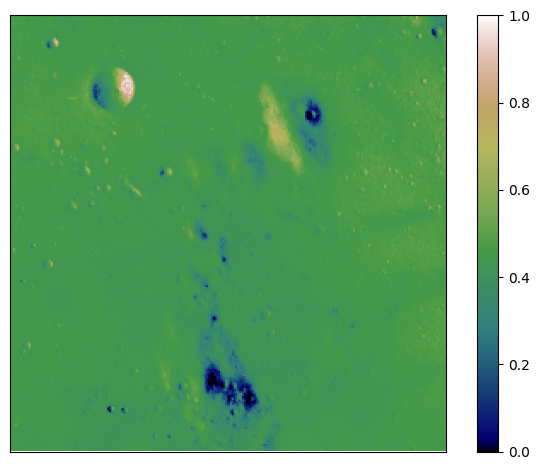

In [19]:
import matplotlib.pyplot as plt
from skimage import data

moon = data.moon().astype(np.float32) / 255.

fig, ax = plt.subplots()
im = ax.imshow(moon, cmap="gist_earth")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.colorbar(im)
fig.tight_layout()

As you can see, the data is really saturated at the lower end. There are almost no values above 0.6.
Let’s write the kernel.

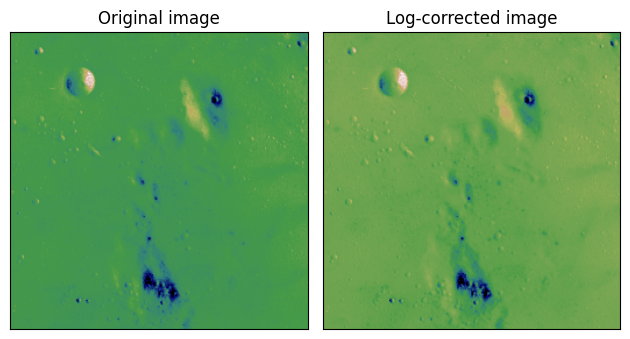

In [20]:
import math

# Example 1.5: 2D kernel
@cuda.jit
def adjust_log(inp, gain, out):
    ix, iy = cuda.grid(2) # The first index is the fastest dimension
    threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2) #  threads per grid dimension

    n0, n1 = inp.shape # The last index is the fastest dimension
    # Stride each dimension independently
    for i0 in range(iy, n0, threads_per_grid_y):
        for i1 in range(ix, n1, threads_per_grid_x):
            out[i0, i1] = gain * math.log2(1 + inp[i0, i1])

threads_per_block_2d = (16, 16)  #  256 threads total
blocks_per_grid_2d = (64, 64)

moon_gpu = cuda.to_device(moon)
moon_corr_gpu = cuda.device_array_like(moon_gpu)

adjust_log[blocks_per_grid_2d, threads_per_block_2d](moon_gpu, 1.0, moon_corr_gpu)
moon_corr = moon_corr_gpu.copy_to_host()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(moon, cmap="gist_earth")
ax2.imshow(moon_corr, cmap="gist_earth")
ax1.set(title="Original image")
ax2.set(title="Log-corrected image")
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()

Let us make note of the two for loops. Notice that that the first for loop starts at iy and the second, innermost loop starts at ix. We could have easily chosen i0 to start at ix and i1 to start at iy instead, which would even feel more natural. So why did we choose this order? It turns out that the memory access pattern for the first choice is more efficient. Since the first grid index is the fastest one, we want to make it match our fastest dimension: the last one.

If you don’t want to take my word for it (and you shouldn’t!) you have now learned how to time kernel executions, and you can try out the two versions. For small arrays such as the one using here, the difference is negligible, but for larger arrays (say 10,000 by 10,000), I have measured a speedup of about 10%. Not super impressive, but if I could give you a 10% improvement with a single swapping of variables, who wouldn’t take it?
And that’s it! We can now see more details in the corrected image.

As an exercise, try timing different launches with different grids to find the optimal grid size for your machine.

# Conclusion

In this tutorial you learned the basics of Numba CUDA. You learned how to create simple CUDA kernels, and move memory to GPU to use them. You also learned how to iterate over 1D and 2D arrays using a technique called grid-stride loops.


# Appendix: Using Nvidia’s cuda-python to probe device attributes

For fine-grained control over the exact attributes of your GPU, you can rely on the lower-level, official CUDA Python package provided by Nvidia.

In [21]:
# Need to: pip install --upgrade cuda-python

from cuda.cuda import CUdevice_attribute, cuDeviceGetAttribute, cuDeviceGetName, cuInit

# Initialize CUDA Driver API
(err,) = cuInit(0)

# Get attributes
err, DEVICE_NAME = cuDeviceGetName(128, 0)
DEVICE_NAME = DEVICE_NAME.decode("ascii").replace("\x00", "")

err, MAX_THREADS_PER_BLOCK = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK, 0
)
err, MAX_BLOCK_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X, 0
)
err, MAX_GRID_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X, 0
)
err, SMs = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT, 0
)

print(f"Device Name: {DEVICE_NAME}")
print(f"Maximum number of multiprocessors: {SMs}")
print(f"Maximum number of threads per block: {MAX_THREADS_PER_BLOCK:10}")
print(f"Maximum number of blocks per grid:   {MAX_BLOCK_DIM_X:10}")
print(f"Maximum number of threads per grid:  {MAX_GRID_DIM_X:10}")

#  Device Name: Tesla T4
#  Maximum number of multiprocessors: 40
#  Maximum number of threads per block:       1024
#  Maximum number of blocks per grid:         1024
#  Maximum number of threads per grid:  2147483647

Device Name: Tesla T4                                                                
Maximum number of multiprocessors: 40
Maximum number of threads per block:       1024
Maximum number of blocks per grid:         1024
Maximum number of threads per grid:  2147483647
